In [ ]:
import numpy as np
import gc


class MyKMeans:
    labels_: np.ndarray
    cluster_centers_: np.ndarray
    distances_: np.ndarray
    n_iters_: int = 0

    def __init__(self, random_state: int = 0, n_clusters: int = 3, heuristic: str = 'k-means++', max_iter: int = 300,
                 eps=1e-4, verbose: int = 0):
        """Simple realisation of K-Means algorithm.


        :param random_state: initialize Mersenne pseudo random with certain seed

        :param n_clusters: defines how many clusters we need to find

        :param heuristic: indicates which of 3 methods of initialisation to use:
            1) 'random' -- cluster centers are initialised with random samples from selection;
            2) 'max_distances' -- first cluster center is initialised with random sample and all the
            others are initialised with the sample that is as remote as possible from previous centers;
            3) 'k-means++' -- quite known algorithm of initialisation, you can
            read about it at https://en.wikipedia.org/wiki/K-means%2B%2B.

        :param max_iter: how many iterations algorithm has to perform if centers don't converge with certain eps

        :param eps: defines a state when we can determine that centers converged

        :param verbose: should we output information about algorithm execution process and how frequently
        """

        self.random_state = random_state

        assert n_clusters > 0, "Parameter 'n_clusters' should be positive"
        self.n_clusters = n_clusters

        assert heuristic in ('random', 'max_distances', 'k-means++'), \
            "Parameter 'heuristic' should be one of ('random', 'max_distances', 'k-means++')"

        self.heuristic = heuristic

        assert max_iter > 0, "Parameter 'max_iter' should be positive"
        self.max_iter = max_iter

        if isinstance(eps, float) or isinstance(eps, int):
            assert eps >= 0, "Parameter 'eps' should be non-negative"
            if eps == 0.:
                eps = -1
            self.eps_ = float(eps)
        else:
            raise ValueError("Parameter 'eps' should be a number")

        self.__dist_from_prev = abs(self.eps_) * (self.n_clusters + 1) + 1
        self.verbose = verbose

    def fit(self, data):
        n_samples = data.shape[0]
        np.random.seed(self.random_state)
        self.cluster_centers_ = np.zeros(shape=(self.n_clusters, data.shape[1]))
        self.labels_ = np.empty(n_samples, dtype='int32')
        self.distances_ = np.empty(n_samples, dtype='int32')
        if self.heuristic == "random":
            # just selecting random samples
            for idx in range(self.n_clusters):
                self.cluster_centers_[idx] = data[np.random.randint(n_samples, size=1), :]
        elif self.heuristic == 'k-means++':
            self.cluster_centers_[0] = data[np.random.randint(n_samples, size=1), :]
            for cluster in range(self.n_clusters)[1:]:
                # assigning every sample the minimum distance from existing centers
                distances = np.amin([np.linalg.norm(data - x, axis=0)
                                     for x in self.cluster_centers_[:cluster]], axis=1)
                rnd = np.random.random() * sum(distances)
                cum_sum = np.cumsum(distances)
                center = data[np.argmax(cum_sum >= rnd), :]
                self.cluster_centers_[cluster] = center
        else:
            # finding samples that are as far as they could be from previous centers
            self.cluster_centers_[0] = data[np.random.randint(n_samples, size=1), :]
            distances = np.zeros(n_samples)
            for idx in range(self.n_clusters)[1:]:
                for cluster in range(idx):
                    distances += np.linalg.norm(data - self.cluster_centers_[cluster], axis=1)
                    self.cluster_centers_[idx] = data[distances.argmax(), :]
        while (self.n_iters_ < self.max_iter) and \
                (self.__dist_from_prev / self.n_clusters >= self.eps_):
            self.__dist_from_prev = 0
            # assigning samples with labels
            tmp = np.array([np.linalg.norm(data - c, axis=1) for c in self.cluster_centers_])
            self.labels_ = tmp.argmin(axis=0)
            self.distances_ = tmp.min(axis=0)

            # recomputing the cluster centers
            for cluster in range(self.n_clusters):
                cardinality = sum(self.labels_ == cluster)
                if cardinality != 0:
                    tmp_clust = sum(data[self.labels_ == cluster]) / cardinality
                    self.__dist_from_prev += np.linalg.norm(tmp_clust - self.cluster_centers_[cluster])
                    self.cluster_centers_[cluster] = tmp_clust
            self.n_iters_ += 1
            if self.verbose and (self.n_iters_ % self.verbose == 0):
                print(f'Iteration №{self.n_iters_}, average distance change = {self.__dist_from_prev}')
        gc.collect()
        return self

    def predict(self, data) -> np.ndarray:
        assert len(self.cluster_centers_[0]) == data.shape[1]
        self.labels_ = np.array([np.linalg.norm(data - c, axis=1) for c in self.cluster_centers_]).argmin(axis=0)
        gc.collect()
        return self.labels_

    def fit_predict(self, data) -> np.ndarray:
        self.fit(data)
        return self.labels_

    def get_params(self) -> dict:
        return {
            'random_state': self.random_state,
            'n_clusters': self.n_clusters,
            'heuristic': self.heuristic,
            'max_iter': self.max_iter,
            'eps': self.eps_,
            'verbose': self.verbose
        }

# Analysis of the implementation
## 1. Comparison with sklearn
So, to start the analysis, I decided to make the most obvious comparison: juxtapose my version of the algorithm and the sklearn one. To do so, I created some simple datasets and visualized the results of both implementations to see the differences. In both algorithms I selected the 'k-means++' initialization.

In [ ]:
from sklearn.datasets import make_blobs
# import dataset maker
from sklearn.cluster import KMeans
# import sklearn version of algorithm to compare

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-dark')

import warnings

warnings.filterwarnings("ignore")

Firstly, we will look into time comparison of the algorithm versions. These are the results that I got on my machine. <u>Note:</u> results may (<b>and should</b>) be different. Especially on multicore computers.

In [ ]:
X, y = make_blobs(10000, 2, random_state=13, centers=3)
% timeit a = KMeans(tol=0.000001, n_clusters=3).fit(X)
% timeit b = MyKMeans(eps=0.000001, n_clusters=3).fit(X)

1.13 s ± 165 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
737 ms ± 4.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


On the plots below the result of the comparison is presented. Different clusters are represented with different colors, and the contrasting dots are cluster centers. As you can see, the output of two algorithms is quite similar: on first dataset the results are nearly identical, on the third one difference is seen in only few dots. A bit dissimilar scenario is observed on the second dataset: the two top left clusters are identified differently by two algorithms.

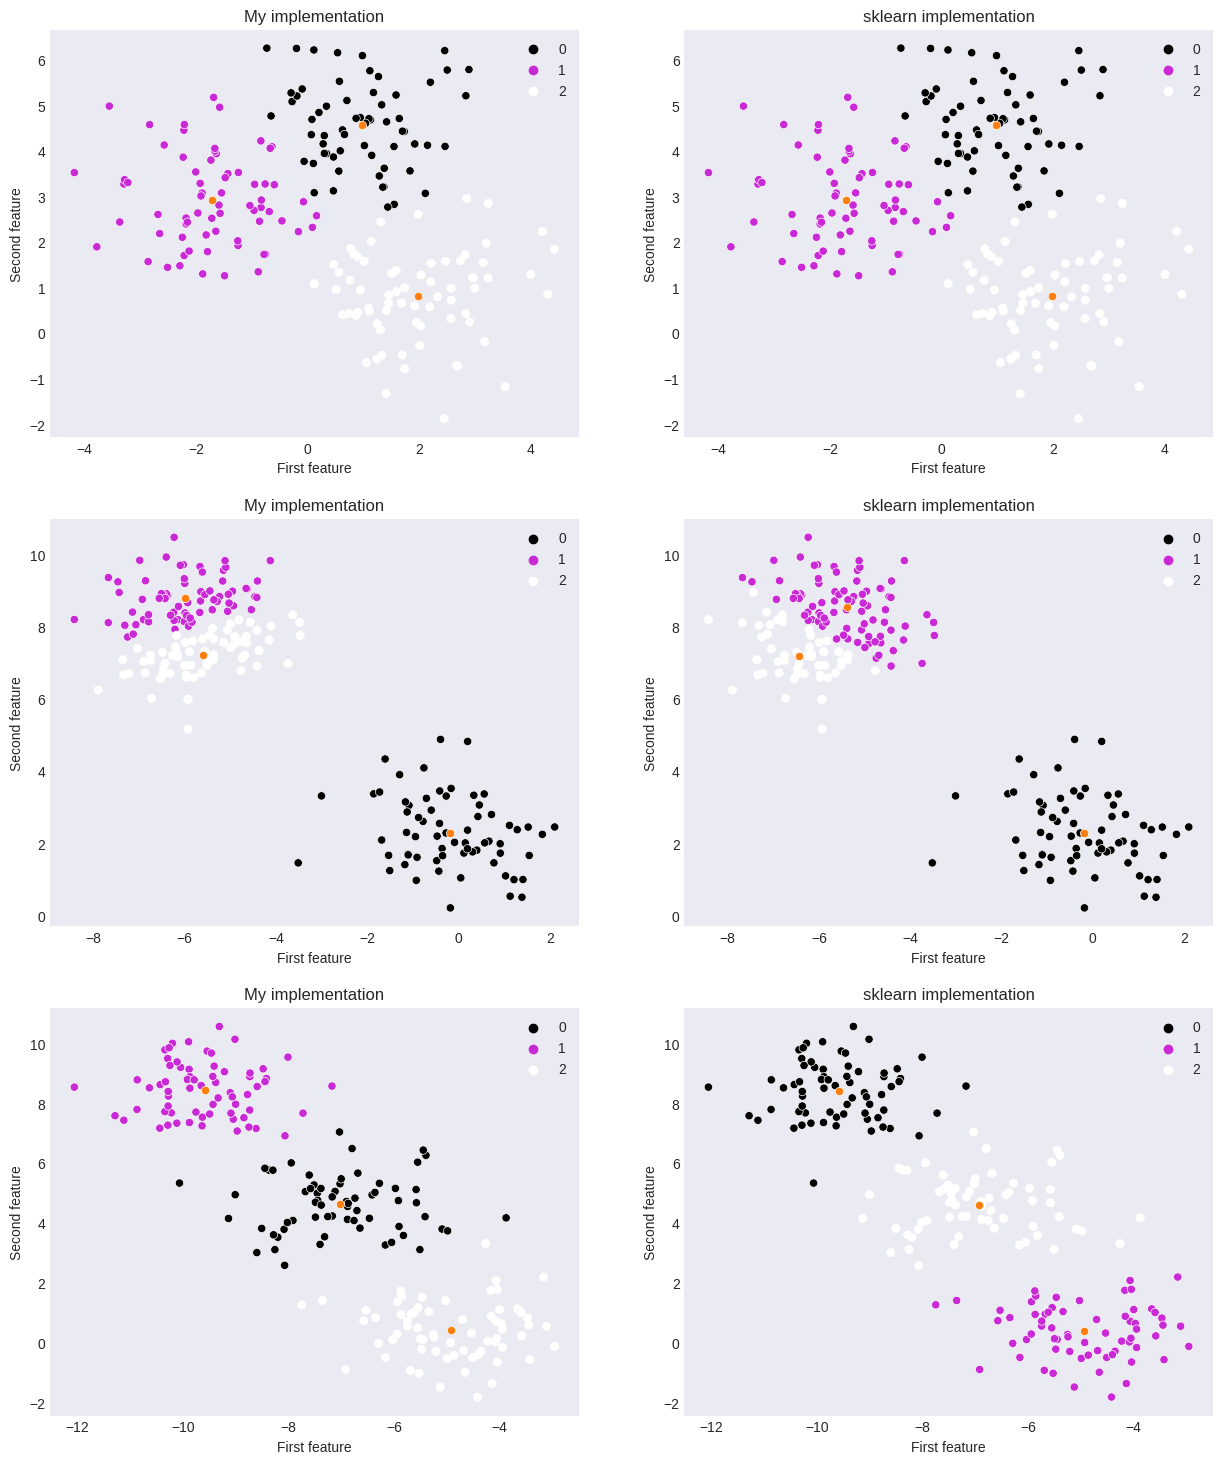

In [ ]:
# comparing the results of realisations of k-means
# on different datasets, using 'k-means++' initialisation
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
for row, sample_seed in enumerate([0, 5, 12]):
    X, y = make_blobs(n_samples=200, n_features=2, centers=3, random_state=sample_seed)
    a = MyKMeans(n_clusters=3, random_state=0, heuristic='k-means++', eps=0.01).fit(X)
    b = KMeans(n_clusters=3, random_state=0, init='k-means++').fit(X)
    for column, implementation in enumerate([(a, "My implementation"), (b, "sklearn implementation")]):
        sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=implementation[0].predict(X), palette='gnuplot2',
                        ax=ax[row, column])
        ax[row, column].set_xlabel("First feature")
        ax[row, column].set_ylabel("Second feature")
        # marking cluster centers
        sns.scatterplot(x=implementation[0].cluster_centers_[:, 0],
                        y=implementation[0].cluster_centers_[:, 1], ax=ax[row, column], palette='gnuplot2')
        ax[row, column].set_title(implementation[1])
plt.show()

Let's research the second dataset situation more closely. We will look at the centers of the clusters provided by the make_blobs function and compare them with the cluster centers returned by k-means algorithms. On the plot below, generated centers are marked in <b>green</b>, and centers produced by the algorithms are marked in <b>orange</b>.

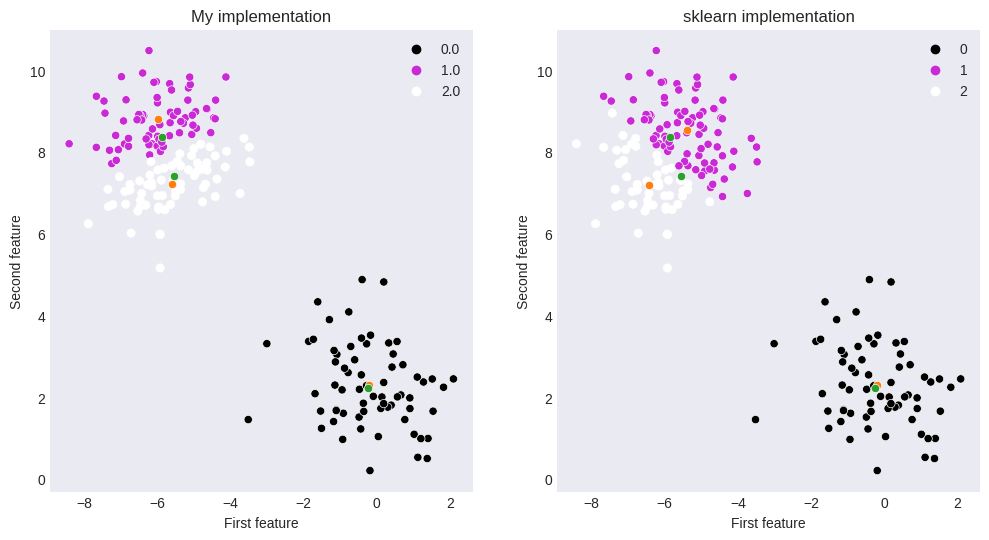

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
X, y, actual_centers = make_blobs(n_samples=200, n_features=2, centers=3, random_state=5, return_centers=True)
a = MyKMeans(n_clusters=3, random_state=0, heuristic='k-means++', eps=0.01).fit(X)
b = KMeans(n_clusters=3, random_state=0, init='k-means++').fit(X)
for column, implementation in enumerate([(a, "My implementation"), (b, "sklearn implementation")]):
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=implementation[0].predict(X), palette='gnuplot2', ax=ax[column])
    # i chose this palette to contrast the centers

    ax[column].set_xlabel("First feature")
    ax[column].set_ylabel("Second feature")

    sns.scatterplot(x=implementation[0].cluster_centers_[:, 0],
                    y=implementation[0].cluster_centers_[:, 1], ax=ax[column])
    sns.scatterplot(x=actual_centers[:, 0], y=actual_centers[:, 1], ax=ax[column], palette="gnuplot2")
    ax[column].set_title(implementation[1])
plt.show()

As we can see, <i>"hand-made"</i> k-means produced cluster centers that are much closer to the original centers, used in the generation of dataset.

## 2. Distance matrices and their sorting techniques
The next step of our analysis would be the distance matrices and different approaches to their sorting. We will examine these approaches on the same exact datasets as in the previous iteration of analysis, and for each dataset we will build three distant matrices: the one that isn't sorted, the one sorted by label and, at last, the one that is sorted by label and then by distance from the corresponding center. I chose this method because it is <b>obvious</b>, <b>explainable</b> and is <b>easy-to-implement</b>.

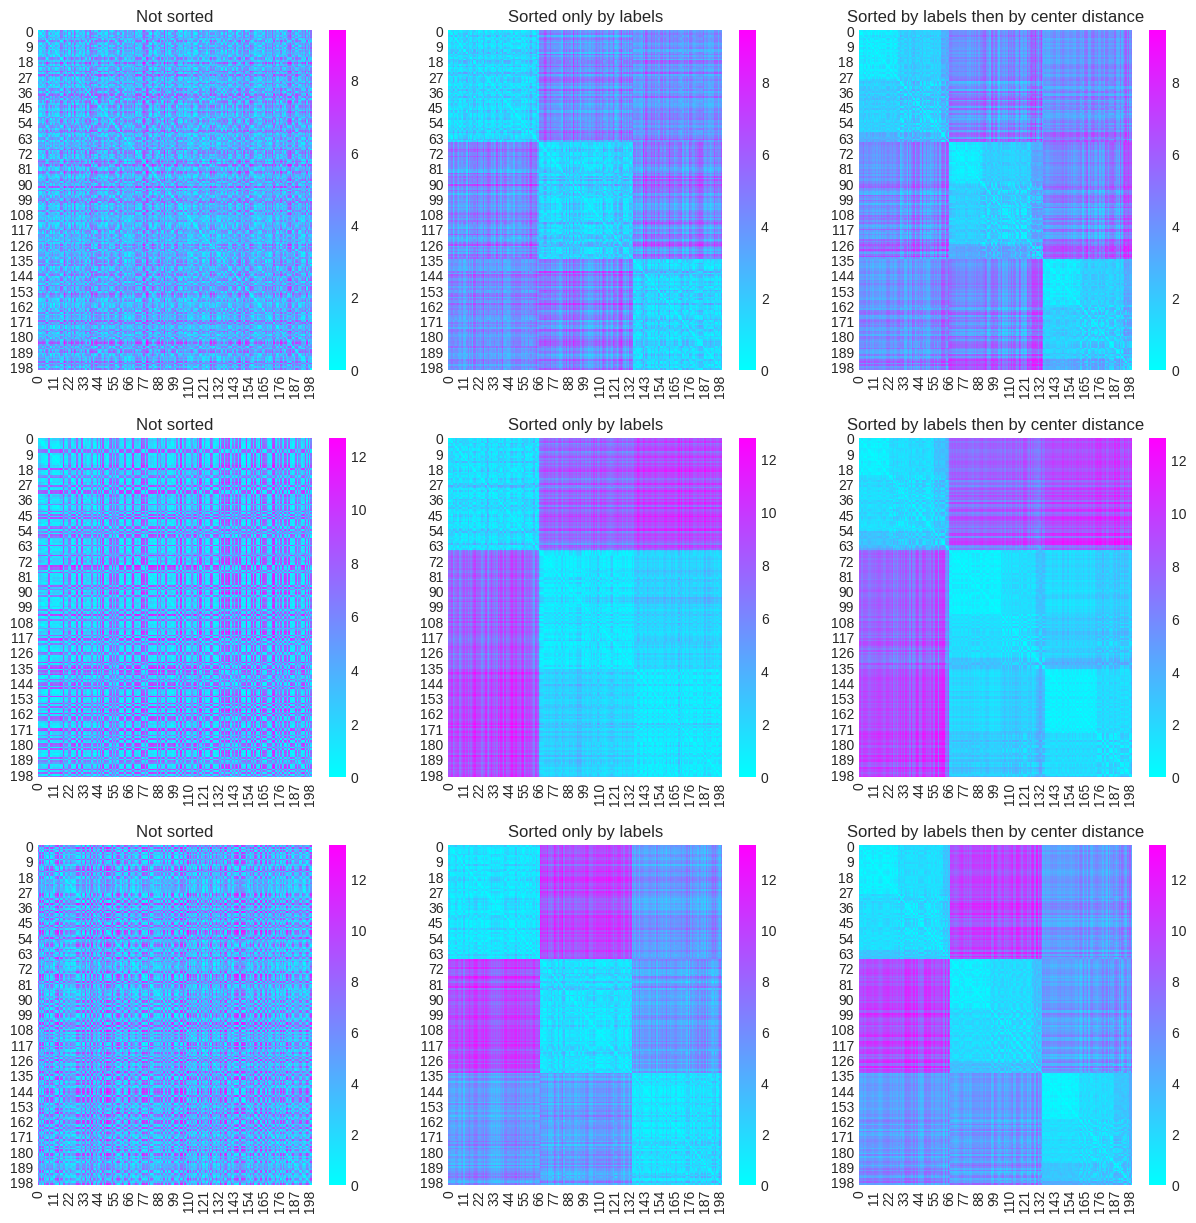

In [ ]:
# sorting the distance matrices by sample labels then by center distances
from scipy.spatial.distance import pdist, squareform

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
for row, sample_seed in enumerate([0, 5, 12]):
    X, y = make_blobs(n_samples=200, n_features=2, centers=3, random_state=sample_seed)
    a = MyKMeans(n_clusters=3, random_state=0, heuristic='k-means++', eps=0.1).fit(X)
    dist_matrices = [
        squareform(pdist(X)),
        # not sorted matrix

        squareform(pdist(sorted(np.insert(X, X.shape[1], a.labels_, axis=1), key=lambda x: x[-1]))),
        # matrix sorted by label

        squareform(pdist(sorted(np.insert(X, X.shape[1], (a.labels_, a.distances_), axis=1),
                                key=lambda x: (x[-2], x[-1]))))
        # matrix sorted by label then by distance from center
    ]
    for column, matrix in enumerate(dist_matrices):
        sns.heatmap(matrix, cmap="cool", ax=ax[row, column])
    for column, string in enumerate(["Not sorted", "Sorted only by labels",
                                     "Sorted by labels then by center distance"]):
        ax[row, column].set_title(string)
plt.show()

This method shows us the average density of the clusters and helps us to indicate <i>"subclusters"</i> inside of the found clusters. For example, on the bottom right plot we can see three distinct squares one inside another in the 3rd cluster. This gives us more information for future investigation and could <i>(but not always does)</i> mean that certain cluster could be divided in greater amount of clusters.

## 3. Estimating the algorithm complexity and analysing the connection between speed and data complexity
We will look how much slower the algorithm will work when the volume and complexity of data increases. At first, we will use datasets generated in the same way as before, but with greater amount of data. We will also see how the execution time of the algorithm depends on the initialization method, but firstly, iterating up to max_iters.

In [ ]:
for n_samples in [100, 1500]:
    for n_features in [2, 5]:
        X, y = make_blobs(n_samples, n_features, random_state=13)
        for heuristic in ['random', 'max_distances', 'k-means++']:
            print(f'Dataset with shape ({n_samples}, {n_features}). '
                  f'Algorithm configuration with {heuristic} initialization time:')
            % timeit MyKMeans(heuristic=heuristic, eps=0.).fit(X)
        print('')  # to divide the output

We can see, that the 'random' is the fastest method in situations with fixed iteration amount and small data volume. It happens because it is the fastest in initialization, and the remaining part of the algorithm is the same for all heuristics. But if we'd do the same operations, but introduced the epsilon parameter first, it would not only speed up the algorithm, but also inverse the race between the initialization methods:

In [ ]:
for n_samples in [100, 1500, 10000, 200000]:
    for n_features in [2, 5, 10, 20]:
        X, y = make_blobs(n_samples, n_features, random_state=13)
        for heuristic in ['random', 'max_distances', 'k-means++']:
            print(f'Dataset with shape ({n_samples}, {n_features}). '
                  f'Algorithm configuration with {heuristic} initialization time: ')
            a = MyKMeans(heuristic=heuristic, eps=0.01)
            % timeit a.fit(X)
            print(f'Amount of iterations equals {a.n_iters_}\n')

# the output of this (and previous) cell is too
# long and it looks awful in github, so i decided
# to clear the output. you'll have to believe i got
# the results stated in markdown or try it out by yourself,
# but the results most probably may be different

Now the 'random' initialization is the slowest on small datasets, and it happens because 'max_distances' and 'k-means++' techniques put the algorithm in a much better position after iteration zero, so it takes more iterations for 'random' to catch up. But on large datasets the situation stays as is, 'random' is still the fastest, even if it takes more iterations to converge.

Apart from the time, we should also compare the quality of the algorithms with and without epsilon parameter:

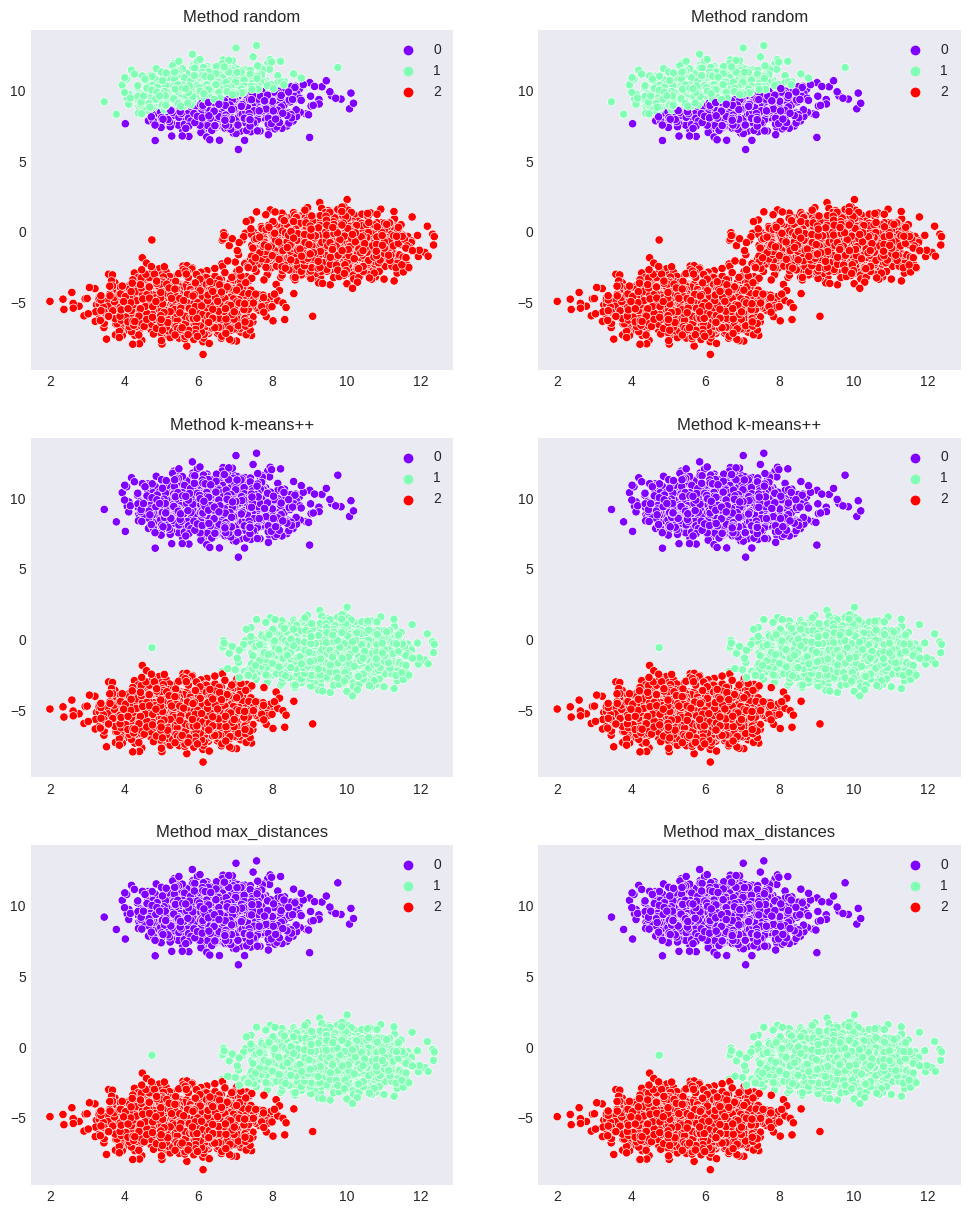

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
X, y = make_blobs(5000, 2, random_state=13, centers=3)
for row, heuristic in enumerate(['random', 'k-means++', 'max_distances']):
    for col, epsilon in enumerate([0.01, 0]):
        a = MyKMeans(heuristic=heuristic, n_clusters=3, eps=epsilon).fit(X)
        sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=a.predict(X), palette='rainbow', ax=ax[row, col])
        ax[row, col].set_title(f"Method {heuristic}")
plt.show()

After this comparison we can not only state that introducing an epsilon parameter speeds up the execution of the algorithm without any quality losses, but also we can note that there are situations, in which 'random' initialization works disappointingly bad comparing to other methods.

## 4. Determining what tasks is algorithm capable for.
Or should i say <b>isn't</b>.
We will observe how algorithm works on some tasks different from the previous ones. We will try out every initialization method on each task, and then we will see how actually these problems should've been solved.

In [ ]:
# !pip install umap-learn
import umap.umap_ as umap
from sklearn.datasets import make_moons, make_classification, make_circles

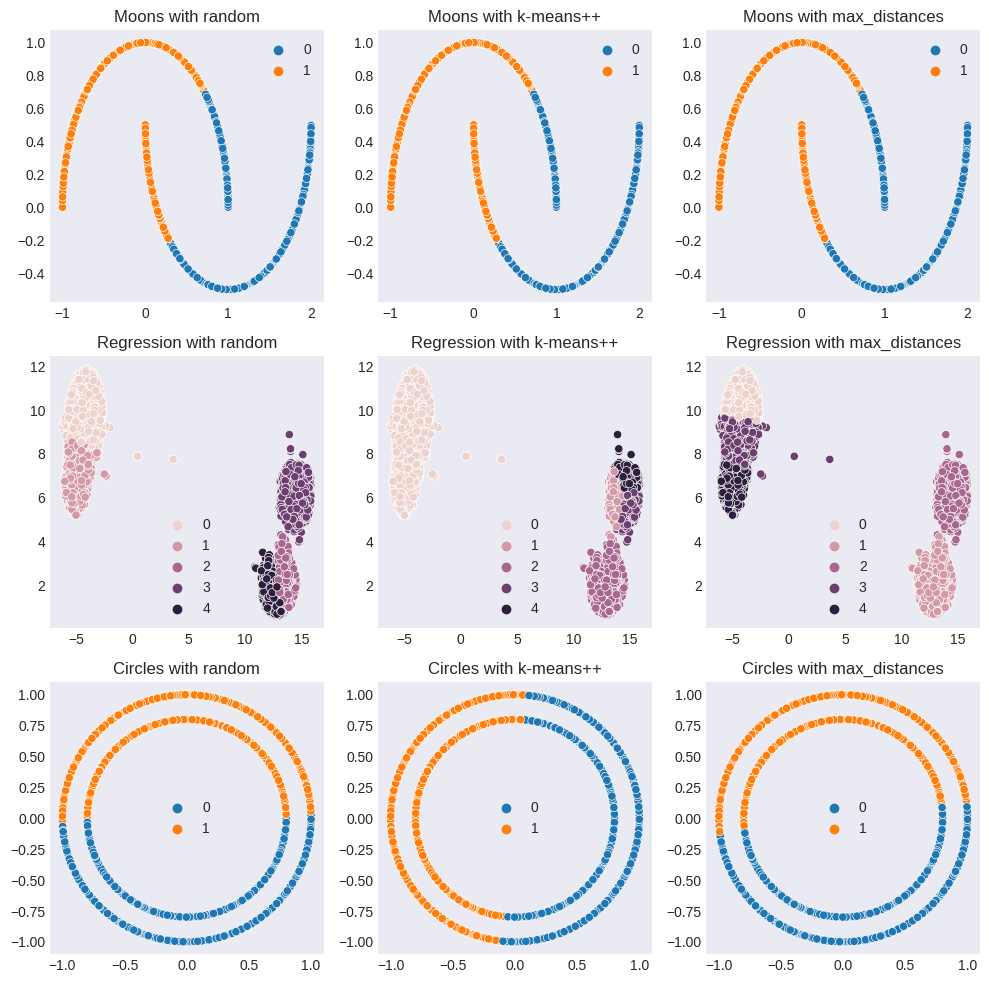

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

X, y = make_moons(n_samples=1500, random_state=0)
for col, method in enumerate(['random', 'k-means++', 'max_distances']):
    a = MyKMeans(n_clusters=2, heuristic=method).fit_predict(X)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=a, ax=ax[0, col])
    ax[0, col].set_title(f'Moons with {method}')

X, y = make_classification(n_samples=5000, n_classes=2, n_features=10, random_state=7)
X = umap.UMAP(n_components=2).fit_transform(X, y)
for col, method in enumerate(['random', 'k-means++', 'max_distances']):
    a = MyKMeans(n_clusters=5, heuristic=method).fit_predict(X)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=a, ax=ax[1, col])
    ax[1, col].set_title(f'Regression with {method}')

X, y = make_circles(n_samples=1500, random_state=0)
for col, method in enumerate(['random', 'k-means++', 'max_distances']):
    a = MyKMeans(n_clusters=2, heuristic=method).fit_predict(X)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=a, ax=ax[2, col])
    ax[2, col].set_title(f'Circles with {method}')
plt.show()

In the first example, we would've want clustering algorithm to distinguish these two <i>"moons"</i>, but it didn't.
Second task was detection of outliers, and kmeans algorithm didn't come up with any good solution.
The third example is similar to the first one: algorithm found two semicircles of <i>"united"</i> circle instead of dividing the inputted dataset into two circles.
We will now look at how these problems should've been solved by the algorithms specifically designed for this:

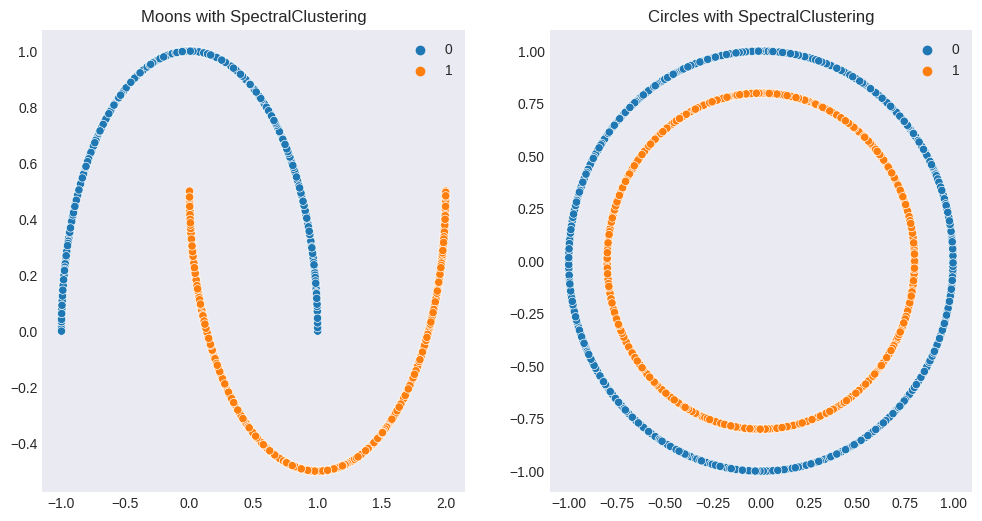

In [ ]:
from sklearn.cluster import SpectralClustering

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
for idx, dataset in enumerate([(make_moons, "Moons"), (make_circles, "Circles")]):
    X, y = dataset[0](n_samples=1500, random_state=0)
    a = SpectralClustering(n_clusters=2, eigen_solver='arpack',
                           affinity="nearest_neighbors").fit_predict(X)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=a, ax=ax[idx])
    ax[idx].set_title(f'{dataset[1]} with SpectralClustering')
plt.show()

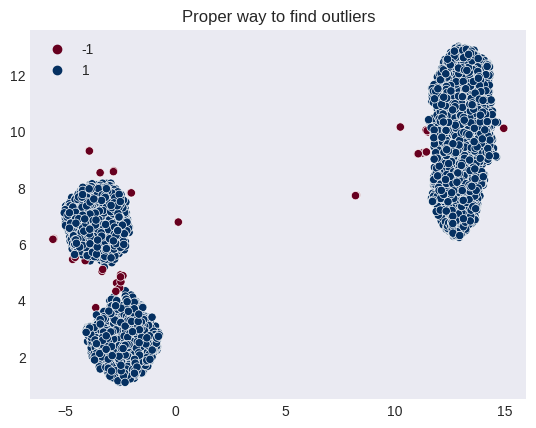

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

X, y = make_classification(n_samples=5000, n_classes=2, n_features=10, random_state=7)
X = umap.UMAP(n_components=2).fit_transform(X, y)
outlier_det = LocalOutlierFactor()
labels = outlier_det.fit_predict(X, y)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette='RdBu')
plt.title("Proper way to find outliers")
plt.show()

## 5. Estimating the optimal amount of clusters
In this section we will examine some methods of choosing the right amount of clusters to divide the data into. The first one is going to be the <i>"elbow"</i> method or Within-Cluster Sum of Squares, which which consists in choosing cost function (for example, sum of all distances between samples and cluster center within each cluster), and plotting its values on each amount of clusters we want to test.

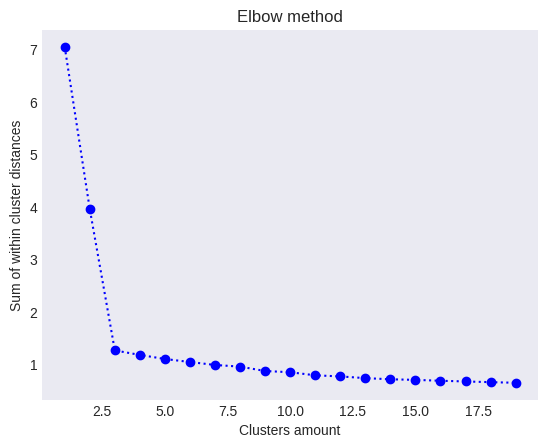

In [ ]:
X, y = make_blobs(n_samples=4000, centers=3)
k_values = range(1, 20)
cost = []
for k in k_values:
    a = MyKMeans(n_clusters=k).fit(X)
    cost.append(sum(a.distances_) / X.shape[0])

plt.plot(k_values, cost, 'ob:')
plt.xlabel("Clusters amount")
plt.ylabel("Sum of within cluster distances")
plt.title("Elbow method")
plt.show()

We can see that there is a huge decrease of cost function between 1 and 3 k values. Based on that plot we can choose our amount of clusters needed to be 3 or more, depends on the situation and our view on it. But this method doesn't quite automates the choose of cluster amount.

The next method is called <b>"Gap Statistic"</b>, invented by Robert Tibshirani, Guenther Walther and Trevor Hastie (you can read about it in [their article](https://web.stanford.edu/~hastie/Papers/gap.pdf). Schematically we can describe this method the following way:
1. For each K in estimated interval we cluster data and compute $W_k = \sum_{k=1}^{K}{\frac{1}{2n_k} D_k}$, where $n_k$ is amount of samples in k-th cluster and $D_k = \sum_{x_i\in C_k}\sum_{x_j\in C_k}\|x_i - x_j\|^2$ - sum of pairwise intra-cluster distances between points in $C_k$ cluster.
2. Generate $B$ <i>reference</i> datasets ($B$ - pre-selected positive number), uniformly over the range of values for each feature in initial dataset, and then cluster them too, computing $W_{kb}^*$ for each $b$ in range $1,...,B$.
3. Compute the Gap Statistic: $Gap(k) = \frac{1}{B} \sum_{b=1}^{B}\log{W_{kb}^*} - \log{W_k}$
4. Let $\tilde{\omega} = \frac{1}{B} \sum_{b=1}^{B}\log{W_{kb}^*}$. Compute standard deviation: $sd(k) = (\frac{1}{B} (\sum_{b=1}^{B}{\log{W_{kb}^*} - \tilde{\omega}})^2)^{\frac{1}{2}}$ and let $s_k = \sqrt{1 + \frac{1}{B}} sd(k)$
5. Finally, choose number of clusters as the smallest $k$, such that $Gap(k) \geq Gap(k + 1) - s_{k+1}$.

In [ ]:
def find_maxmins(X):
    x_min, x_max = min(X, key=lambda a: a[0])[0], max(X, key=lambda a: a[0])[0]
    y_min, y_max = min(X, key=lambda a: a[1])[1], max(X, key=lambda a: a[1])[1]
    return (x_min, x_max), (y_min, y_max)


def compute_Wk(centers, cluster_labels, data):
    k = len(centers)
    return sum([sum(np.linalg.norm(centers[i] - data[cluster_labels == i, :], axis=1) ** 2) /
                (2 * sum(cluster_labels == i))
                for i in range(k)])


def gap_stat_method(X, k_amount=13, ref_datasets_amount=20):
    np.random.seed(0)
    (x_min, x_max), (y_min, y_max) = find_maxmins(X)

    disp_k = np.zeros(k_amount)
    k_ref_disp = np.zeros(k_amount)
    sk = np.zeros(k_amount)
    for i, k in enumerate(range(1, k_amount)):
        a = MyKMeans(n_clusters=k)
        a.fit(X)
        centers = a.cluster_centers_
        disp_k[i] = np.log(compute_Wk(centers, a.labels_, X))

        refdisps = np.zeros(ref_datasets_amount)
        for idx in range(ref_datasets_amount):
            Xb = []
            for n in range(len(X)):
                Xb.append([np.random.uniform(x_min, x_max),
                           np.random.uniform(y_min, y_max)])
            Xb = np.array(Xb)
            b = MyKMeans(n_clusters=k)
            b.fit(Xb)
            ref_clusters = b.cluster_centers_
            refdisps[idx] = np.log(compute_Wk(ref_clusters, b.labels_, Xb))
        k_ref_disp[i] = sum(refdisps) / ref_datasets_amount
        sk[i] = np.sqrt(sum((refdisps - k_ref_disp[i]) ** 2) / ref_datasets_amount)
    return k_ref_disp - disp_k, sk

Now we will try it out:

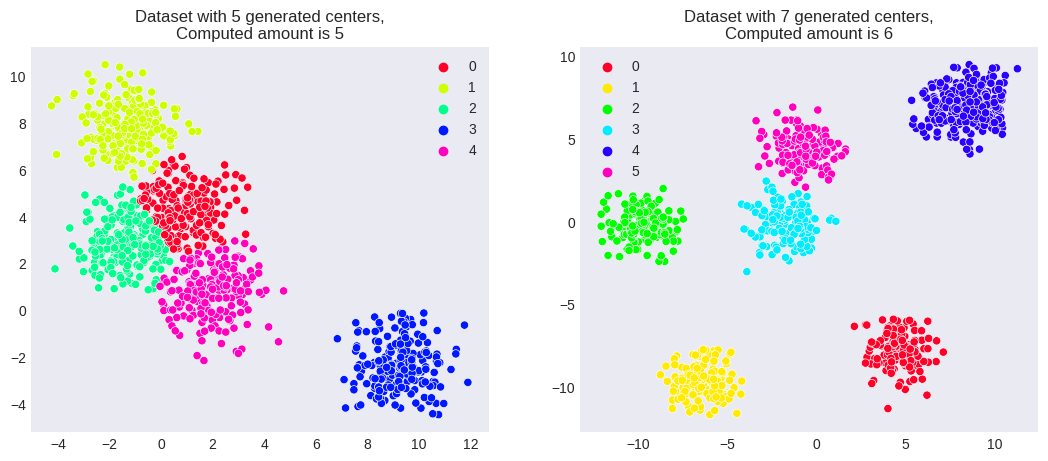

In [ ]:
fid, ax = plt.subplots(ncols=2, figsize=(13, 5))
for idx, (centers, seed) in enumerate([(5, 0), (7, 11)]):
    X, y = make_blobs(n_samples=1000, centers=centers, random_state=seed)
    gaps, sk = gap_stat_method(X)
    gap_find = (gaps[:-1] - gaps[1:] + sk[1:]) > 0
    opt_k = np.argmax(gap_find) + 1
    # because indexation begins with zero, and first k equals 1

    a = MyKMeans(n_clusters=opt_k)
    a.fit(X)
    sns.scatterplot(X[:, 0], X[:, 1], ax=ax[idx], hue=a.labels_, palette='gist_rainbow')
    ax[idx].set_title(f'Dataset with {centers} generated centers,\n'
                      f'Computed amount is {opt_k}')

plt.show()